Orderbook from Day 3

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

np.random.seed(42)

class OrderBook:
    def __init__(self, initial_price=100.0, volatility_factor=0.5):
        self.bids = []  # List of [price, quantity]
        self.asks = []  # List of [price, quantity]
        self.mid_price = initial_price
        self.volatility_factor = volatility_factor 
        self.history = [] 

    def add_random_orders(self, num_orders=10):
        """Simulate incoming limit orders around the mid_price"""
        for _ in range(num_orders):
            side = np.random.choice(['bid', 'ask'])
            
            offset = np.abs(np.random.normal(0, self.volatility_factor))
            qty = np.random.randint(1, 100)

            if side == 'bid':
                price = np.round(self.mid_price - offset, 2)
                self.bids.append([price, qty])
            else:
                price = np.round(self.mid_price + offset, 2)
                self.asks.append([price, qty])
        
        # Sort books: Bids descending, Asks ascending
        self.bids = sorted(self.bids, key=lambda x: x[0], reverse=True)
        self.asks = sorted(self.asks, key=lambda x: x[0])
        
        while self.bids and self.asks and self.bids[0][0] >= self.asks[0][0]:
            best_bid = self.bids[0] 
            best_ask = self.asks[0] 
            
            trade_qty = min(best_bid[1], best_ask[1])
            
            best_bid[1] -= trade_qty
            best_ask[1] -= trade_qty
            
            if best_bid[1] == 0:
                self.bids.pop(0)
                
            if best_ask[1] == 0:
                self.asks.pop(0)
                
        self._record_metrics()

    def _record_metrics(self):
        """Record the current spread for analysis"""
        if self.bids and self.asks:
            best_bid = self.bids[0][0]
            best_ask = self.asks[0][0]
            spread = best_ask - best_bid
            self.mid_price = (best_bid + best_ask) / 2
            self.history.append({'time': len(self.history), 'spread': spread, 'mid': self.mid_price})

    def get_depth_frame(self):
        """Return dataframes for plotting"""
        df_bids = pd.DataFrame(self.bids, columns=['price', 'quantity'])
        df_asks = pd.DataFrame(self.asks, columns=['price', 'quantity'])
        
        if not df_bids.empty:
            df_bids = df_bids.groupby('price').sum().reset_index().sort_values('price', ascending=False)
        if not df_asks.empty:
            df_asks = df_asks.groupby('price').sum().reset_index().sort_values('price', ascending=True)
        
        return df_bids, df_asks

Order and Trade 

In [2]:
from dataclasses import dataclass, field
import time

@dataclass
class Order:
    id: int
    agent_id: int
    side: str # 'buy' or 'sell'
    price: float
    quantity: int
    timestamp: float 

@dataclass
class Trade:
    time: float
    price: float
    quantity: int
    buyer_id: int
    seller_id: int
    aggressor_side: str


Base Agent Class

In [4]:
class Agent:
    def __init__(self, agent_id, initial_cash = 100000, initial_inventory = 0):
        self.id = agent_id
        self.cash = initial_cash
        self.inventory = initial_inventory
        self.order_id_counter = 0

    def act(self, market_snapshot):
        raise NotImplementedError("Each agent must implement an 'act' method")

Trading Agents 

In [5]:
class NoiseTrader(Agent):
    """
    Simulates a random retail trader.
    Strategies: Randomly buys or sells at the market price.
    """
    def act(self, market_snapshot):
        # 10% chance to trade at any given second
        if np.random.random() < 0.1: 
            side = np.random.choice(['buy', 'sell'])
            # Simple Market Order logic:
            # If buy, aim slightly above best ask to ensure fill
            # If sell, aim slightly below best bid
            best_bid = market_snapshot['best_bid']
            best_ask = market_snapshot['best_ask']
            
            price = best_ask if side == 'buy' else best_bid
            return Order(id=np.random.randint(1e6), agent_id=self.id, 
                         side=side, price=price, quantity=10, timestamp=time.time())
        return None

class MarketMaker(Agent):
    """
    Provides liquidity. Places orders on BOTH sides.
    """
    def act(self, market_snapshot):
        mid_price = (market_snapshot['best_bid'] + market_snapshot['best_ask']) / 2
        spread = 0.50 # Fixed spread profit
        
        # Place a Buy order below mid and Sell order above mid
        buy_order = Order(id=np.random.randint(1e6), agent_id=self.id, side='buy', 
                          price=mid_price - spread/2, quantity=100, timestamp=time.time())
        
        sell_order = Order(id=np.random.randint(1e6), agent_id=self.id, side='sell', 
                           price=mid_price + spread/2, quantity=100, timestamp=time.time())
        
        return [buy_order, sell_order]

Market env

Starting Day 4 Simulation...
Simulation Done. Total Trades: 25


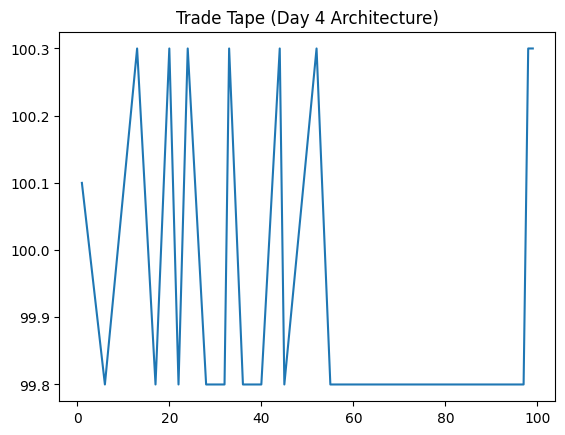

In [ ]:
class MarketEnvironment:
    def __init__(self, matching_engine):
        self.book = matching_engine
        self.agents = []
        self.time = 0
        self.trades = [] # The "Tape"
        
    def add_agent(self, agent):
        self.agents.append(agent)
        
    def get_snapshot(self):
        # Expose L1 Data (Top of Book) to agents
        # (Handling empty book cases for safety)
        best_bid = self.book.bids[0][0] if self.book.bids else 100.0
        best_ask = self.book.asks[0][0] if self.book.asks else 100.1
        return {'best_bid': best_bid, 'best_ask': best_ask, 'time': self.time}
    
    def step(self):
        """
        The Main Event Loop (1 Tick)
        """
        self.time += 1
        snapshot = self.get_snapshot()
        
        for agent in self.agents:
            orders = agent.act(snapshot)
            
            # Handle single order or list of orders
            if orders:
                if not isinstance(orders, list):
                    orders = [orders]
                    
                for order in orders:
                    if order.side == 'buy':
                        self.book.bids.append([order.price, order.quantity])
                    else:
                        self.book.asks.append([order.price, order.quantity])
        
        # Re-sort and Clean book (The Matching Engine Logic)
        self.book.bids = sorted(self.book.bids, key=lambda x: x[0], reverse=True)
        self.book.asks = sorted(self.book.asks, key=lambda x: x[0])
        
        # Simple Matching check (Day 3 logic)
        while self.book.bids and self.book.asks and self.book.bids[0][0] >= self.book.asks[0][0]:
            price = self.book.bids[0][0]
            qty = min(self.book.bids[0][1], self.book.asks[0][1])
            
            # Record Trade
            self.trades.append({'time': self.time, 'price': price, 'qty': qty})
            
            # Remove filled orders (Simple pop for now)
            self.book.bids.pop(0)
            self.book.asks.pop(0)

# --- RUNNING THE ARCHITECTURE ---
# 1. Initialize System
engine = OrderBook() 
env = MarketEnvironment(engine)

# 2. Add Agents
env.add_agent(MarketMaker(agent_id=1))
env.add_agent(NoiseTrader(agent_id=2))
env.add_agent(NoiseTrader(agent_id=3))

# 3. Run Simulation Loop
print("Starting Day 4 Simulation...")
for _ in range(100):
    env.step()

print(f"Simulation Done. Total Trades: {len(env.trades)}")
# Plotting trade tape
trades_df = pd.DataFrame(env.trades)
if not trades_df.empty:
    plt.plot(trades_df['time'], trades_df['price'])
    plt.title("Trade Tape (Day 4 Architecture)")
    plt.show()